# Import the libraries


In [1]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import shutil
import os

/home/mikhail/miniconda3/envs/catrecogai/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/mikhail/miniconda3/envs/catrecogai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

2025-05-14 01:49:23.457935: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 01:49:23.466225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747180163.474957    8595 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747180163.477694    8595 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747180163.485248    8595 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Num GPUs Available:  1


# Download the dataset


In [3]:
path = kagglehub.dataset_download("crawford/cat-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/mikhail/.cache/kagglehub/datasets/crawford/cat-dataset/versions/2


# Inspect the dataset

## List the files in the dataset directory


In [4]:
print("Files in the dataset directory:")
for folder in os.listdir(path):
    print(f"Folder {folder} has {len(os.listdir(os.path.join(path, folder)))} files ")

if 'data' not in os.listdir():
    os.mkdir("data")

Files in the dataset directory:
Folder CAT_02 has 0 files 
Folder CAT_03 has 0 files 
Folder CAT_00 has 0 files 
Folder CAT_06 has 0 files 
Folder CAT_05 has 0 files 
Folder CAT_04 has 0 files 
Folder CAT_01 has 0 files 


## Move the images and the .cat files in different folders


In [5]:
if 'images' not in os.listdir("data"):
    os.mkdir("data/images/no_category")
if 'cat_files' not in os.listdir("data"):
    os.mkdir("data/cat_files")

## Move the images and the .cat files in different folders


In [6]:
for folder in os.listdir(path):
    for file in os.listdir(os.path.join(path, folder)):
        if file.endswith(".cat"):
            shutil.move(os.path.join(path, folder, file), os.path.join("data/cat_files", file))
        else:
            shutil.move(os.path.join(path, folder, file), os.path.join("data/images/no_category", file))


In [7]:
## List the files in the images directory
print(f"The images directory has {len(os.listdir('data/images/no_category'))} files")
## List the files in the cat_files directory
print(f"The cat_files directory has {len(os.listdir('data/cat_files'))} files")

The images directory has 9993 files
The cat_files directory has 9993 files


# Model

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

## Image preprocessing

In [9]:
img_height = 150
img_width = 150
batch_size = 32

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "data/images",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9993 files belonging to 1 classes.
Using 7995 files for training.


I0000 00:00:1747180164.794148    8595 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9321 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "data/images",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9993 files belonging to 1 classes.
Using 1998 files for validation.


2025-05-14 01:49:25.658180: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


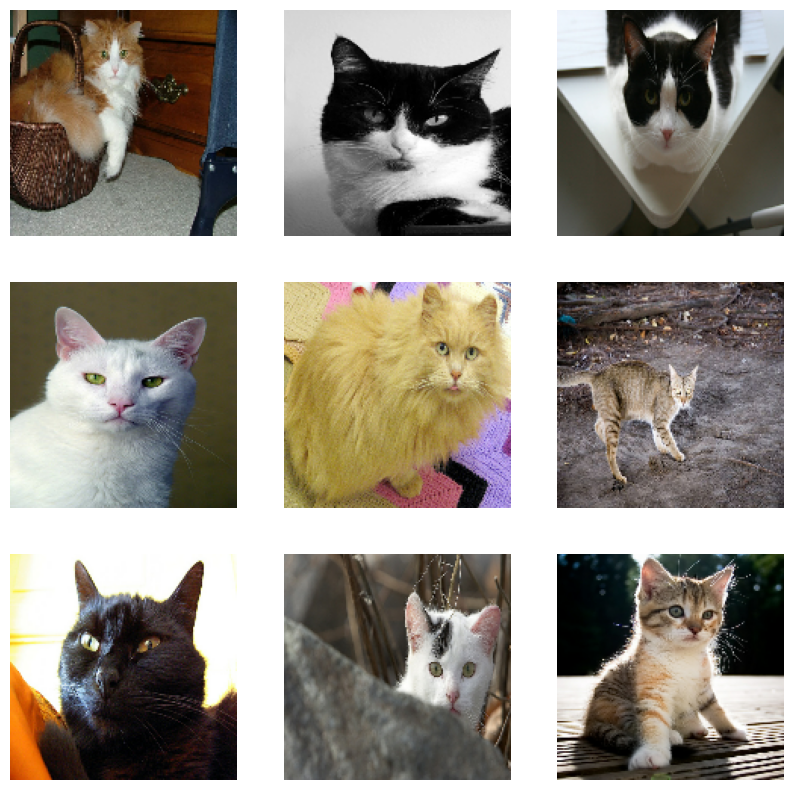

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")


In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [22]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [23]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [24]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


/home/mikhail/miniconda3/envs/catrecogai/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9757 - loss: 0.0390 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [25]:
model.evaluate(val_ds)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00


[0.0, 1.0]

In [30]:
# Save the model
model.save("cat_classifier_model.keras")

In [31]:
validation_image = val_ds.take(1)
for images, labels in validation_image:
    image = images[0]
    label = labels[0]

# Load the model
model = tf.keras.models.load_model("cat_classifier_model.keras")
predictions = model.predict(tf.expand_dims(image, axis=0))
predicted_label = np.argmax(predictions[0])
print(f"Predicted label: {predicted_label}")
print(f"True label: {label.numpy()}")

2025-05-14 01:53:00.390861: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/mikhail/miniconda3/envs/catrecogai/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Predicted label: 0
True label: 0
